# Modelling, Part 2: less features + feature selection

We have two version here, one with the f-ANOVA and one with mutual information

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import pickle
import pathlib
import tqdm
import numpy as np
import numpy.random
import pandas as pd
from sklearn import svm
import sklearn.metrics as metr
import sklearn.preprocessing as pp
import sklearn.linear_model as lm
import sklearn.neighbors.nearest_centroid as nc
import sklearn.neighbors as ne
import sklearn.naive_bayes as nb
import sklearn.ensemble as em
import sklearn.discriminant_analysis as da
import sklearn.gaussian_process as gp
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.base import clone
import sklearn.model_selection as ms
import gestureanalysis.svm_helpers as svmhelper
import sklearn.utils
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
base_path = "/home/jsimon/Documents/thesis/gesture-analysis/data/"
time_groups_path_corrected_pickl = base_path+"transformed/time_added/all/time-and-groups-corrected-all.pkl"
stats_added_base_path = base_path+"transformed/stats_added/all/"
stats_added_path_pickl = stats_added_base_path+"raw_stats-added-all.pkl"
gyro_calibration_path = base_path+'../scripts/gestureanalysis/gyro_offset.txt'

In [4]:
import os
os.getcwd()

'/home/jsimon/Documents/thesis/gesture-analysis/scripts'

## First work with the f-ANOVA60 Dataset

In [5]:
with open( stats_added_base_path+'train-data-scaled-f-ANOVA60.pkl', "rb" ) as users_pickle_file:
    data = pickle.load(users_pickle_file)

In [6]:
X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']
gestures = data['gestures']
features = data['headers']

In [7]:
X, y = sklearn.utils.shuffle(X, y)

In [8]:
del [[data]]
gc.collect()
data = pd.DataFrame()
gc.collect()

0

## List of classifiers

Many classifiers did not work with the 6k feature set. Let's see which work with the 3k set.

In [9]:
# start with some list, and remove then when the classifier takes too long
classifiers = [#("lin svc",svm.LinearSVC(class_weight='balanced', verbose=True)), #takes too long (stopped after 1h)
               #("gaussian process", gp.GaussianProcessClassifier(n_jobs=3)), #Memory error
               #("gaussian process w. restarts", gp.GaussianProcessClassifier(n_restarts_optimizer=3, n_jobs=3)), #, Memory error
               #("lr-newton",lm.LogisticRegression(solver='newton-cg', multi_class='auto', class_weight='balanced', n_jobs=3, verbose=True)), #takes too long (stopped after 2h)
               #("lr-sag",lm.LogisticRegression(solver='sag', multi_class='auto', class_weight='balanced', n_jobs=3, verbose=True)), # takes too long (stopped after 2h)
               #("lr-saga",lm.LogisticRegression(solver='saga', multi_class='auto', class_weight='balanced', n_jobs=3, verbose=True)), # takes too long (stopped after 2h)
               ("passive agressive", lm.PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, class_weight='balanced', n_jobs=3)), # put verbose away, too much output
               #("lr(l1)",lm.LogisticRegression(penalty='l1', class_weight='balanced', n_jobs=3, verbose=True)), # kernel died
               ("sgd[hinge]",lm.SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, tol=1e-3, class_weight='balanced', n_jobs=3)), # put verbose away, too much output
               ("LDA", da.LinearDiscriminantAnalysis()),
               ("QDA", da.QuadraticDiscriminantAnalysis()),
               ("nn",nc.NearestCentroid()),
               #("knn",ne.KNeighborsClassifier(n_jobs=3)), # fitting worked, but prediction takes to long as this scales with the data
               #("rnc",ne.RadiusNeighborsClassifier(radius=3.0, n_jobs=3)), # could not find a good distance, tried 1 and 3
               ("gaussian navie bayse",nb.GaussianNB()),
               ("decision tree",tree.DecisionTreeClassifier(class_weight='balanced')), # timed out
               ("random forrest",em.RandomForestClassifier(n_estimators=10, class_weight='balanced', n_jobs=3, verbose=True)),
               ("extra trees",em.ExtraTreesClassifier(n_estimators=10, class_weight='balanced', n_jobs=3, verbose=True)),
               #("bagging kn",em.BaggingClassifier(ne.KNeighborsClassifier(), max_samples=0.5, max_features=0.5, verbose=True)), #timed out after 1h
               #("bagging svc",em.BaggingClassifier(svm.SVC(decision_function_shape='ovo', class_weight='balanced'),max_samples=0.5, n_jobs=3, max_features=0.5, verbose=True)), # timed out after 1h
               ("ada boost",em.AdaBoostClassifier(n_estimators=100))
               #("gradient boost",em.GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0, verbose=True)) # timed out, says after 1h running that it still has 400 open
]

In [10]:
def fit_classifier(classifiers, X, y, Xval, yval):
    clf = None
    clf_n = None
    
    results = []
    progress = tqdm.tqdm_notebook(classifiers)
    for clf_name, clf_candidate in progress:
        progress.set_description(clf_name)
        clf_candidate = clone(clf_candidate)
        gc.collect()
        progress.set_description(clf_name + ' cloned')
        clf_candidate.fit(X, y)
        progress.set_description(clf_name + ' fittet')
        p = clf_candidate.predict(Xval)
        s = f1_score(yval, p, average='micro')
        p_t = clf_candidate.predict(X)
        s_t = f1_score(y, p_t, average='micro')
        print(f"val score {s} for {clf_name} (test: {s_t})")
        cmatrix = metr.confusion_matrix(yval, p)
        #print(cmatrix)
        results.append((clf_name, s, s_t, cmatrix, clf_candidate))
        gc.collect()

    return results

In [11]:
gc.collect()
results = fit_classifier(classifiers, X, y, Xval, yval)

val score 0.8309085030714517 for passive agressive (test: 0.8277799252673624)
val score 0.6154219204655674 for sgd[hinge] (test: 0.6654554825409097)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.9398642095053347 for LDA (test: 0.9368122664605076)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.5279663756870352 for QDA (test: 0.8227676845767299)
val score 0.11590688651794374 for nn (test: 0.053704419533565265)
val score 0.5690268347882315 for gaussian navie bayse (test: 0.7106687282566679)
val score 0.9214354995150339 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   22.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9574846427416748 for random forrest (test: 0.9976678263110423)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.960717749757517 for extra trees (test: 1.0)
val score 0.11849337213061753 for ada boost (test: 0.5562685220976679)



In [13]:
with open( stats_added_base_path+'fANOVA-clss.pkl', "wb" ) as users_pickle_file:
    pickle.dump(results, users_pickle_file)

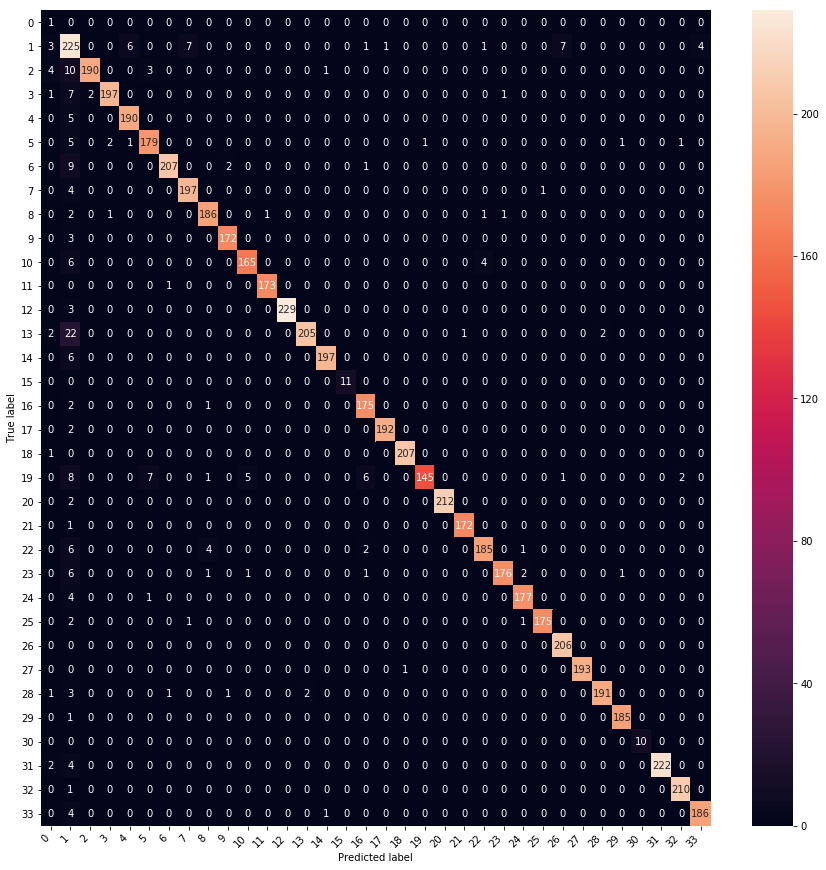

In [14]:
f, axarr = plt.subplots(figsize=(15, 15))
heatmap = sns.heatmap(results[-2][3], annot=True, fmt="d", ax=axarr)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Now try the Mutual Information 60 Dataset

In [15]:
# clean the old data
del [[X,y,Xval,yval,features,results]]
gc.collect()
X,y,Xval,yval,features,results = None, None, None, None, None, None
gc.collect()

0

In [16]:
with open( stats_added_base_path+'train-data-scaled-mutual-inf60.pkl', "rb" ) as users_pickle_file:
    data = pickle.load(users_pickle_file)

In [17]:
X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']
gestures = data['gestures']
features = data['headers']

In [18]:
X, y = sklearn.utils.shuffle(X, y)

In [19]:
del [[data]]
gc.collect()
data = pd.DataFrame()
gc.collect()

0

Since the reason the classifiers do not work is the datasize, and this dataset has the same size, let's just assume it are the same who would time out

In [20]:
gc.collect()
results = fit_classifier(classifiers, X, y, Xval, yval)

val score 0.38086000646621404 for passive agressive (test: 0.4722071897951295)
val score 0.07775622373100549 for sgd[hinge] (test: 0.32513851307821157)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


val score 0.9405108309085031 for LDA (test: 0.9368638062105399)


/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/jsimon/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/discriminant_analysis.py

val score 0.5559327513740705 for QDA (test: 0.8477000386548125)
val score 0.05948916909149692 for nn (test: 0.5111197010694498)
val score 0.38861946330423536 for gaussian navie bayse (test: 0.6188377786367736)
val score 0.9270934367927578 for decision tree (test: 1.0)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   23.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.9597478176527643 for random forrest (test: 0.9976549413735344)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished


val score 0.959262851600388 for extra trees (test: 1.0)
val score 0.16036210798577433 for ada boost (test: 0.5693853884808658)



In [21]:
with open( stats_added_base_path+'mutual-inf-clss.pkl', "wb" ) as users_pickle_file:
    pickle.dump(results, users_pickle_file)

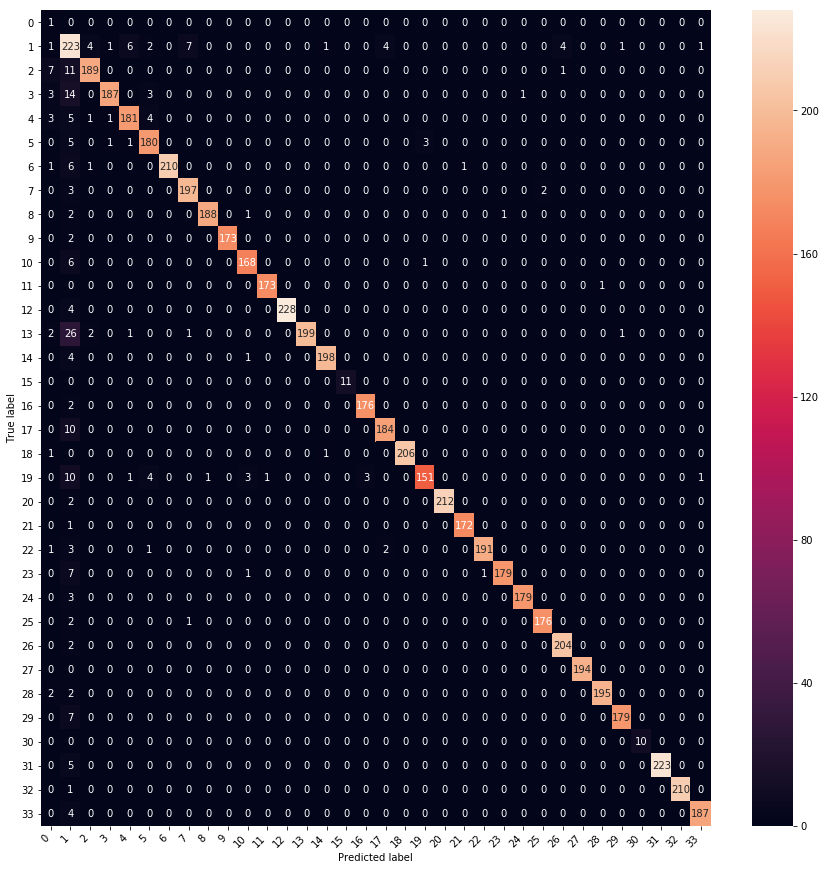

In [22]:
f, axarr = plt.subplots(figsize=(15, 15))
heatmap = sns.heatmap(results[-2][3], annot=True, fmt="d", ax=axarr)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()